In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.io as io
from Pred_local_lifetime import LLE
from Prep_exp_data import prep_exp_data
from Neural_implict_interploation import NIII_process
from utils import plot_image, plot_images,timer
import warnings
import mat73
warnings.filterwarnings('ignore')

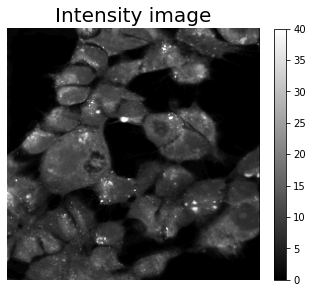

In [9]:
#load data
sample_file = 'hek_low'
data = io.loadmat(f'./sample_data/{sample_file}.mat')
hist = data['hist'].astype('float32')
irf = data['irf'].astype('float32')
GT = mat73.loadmat('./sample_data/hek_gt.mat')
tau_img_GT = GT['tau_img_gt'].astype('float32')
Int = hist.sum(2)
plot_image(Int, title = 'Intensity image',  max_value = 40)

In [10]:
patch_size = 8
int_thres = 3
Int[Int<=int_thres]=0 
Mask = Int
hist2d_mask = hist
for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        if Mask[i,j]==0:
            hist2d_mask[i,j,:]=np.zeros(256)
            
Int_Mask = hist2d_mask.sum(-1)

#% Step 1 Evaluating local fluorescence lifetime
lr_tau = LLE(hist2d_mask,irf,r = patch_size, bin_w = 0.039, p_path = r'./model_parameters/LLE_parameter_1_3ns.pth')

#% Step 2, Neural implict interploation
nii_data = prep_exp_data(Int_Mask,lr_tau).prep_data()

result = NIII_process(nii_data,ratio = patch_size)
pred_image =np.squeeze(result,(0,1)) 
pred_image[pred_image<0] = 0

Complete 'LLE' in 0.2115 secs
Complete 'NIII_process' in 0.3971 secs


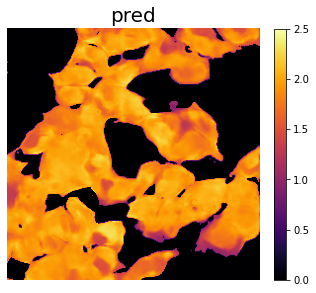

In [11]:
plot_image(pred_image, title = 'pred',min_value = 0, max_value = 2.5,colormap='inferno')

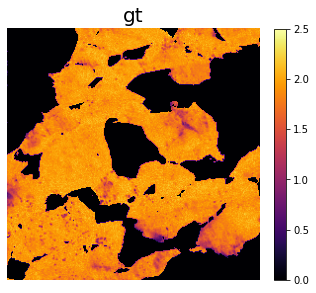

In [12]:
plot_image(tau_img_GT, title = 'gt',min_value = 0, max_value = 2.5, colormap = 'inferno')

Text(0, 0.5, 'Counts')

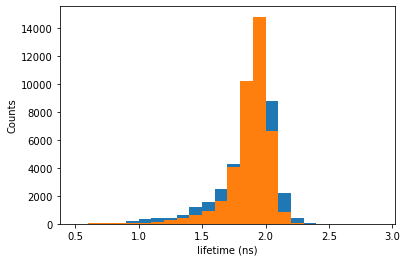

In [13]:
plt.hist(pred_image.reshape(-1),bins=np.arange(0.5,3,0.1))
plt.hist(tau_img_GT.reshape(-1),bins=np.arange(0.5,3,0.1))
plt.xlabel('lifetime (ns)')
plt.ylabel('Counts')